In [120]:
import math
from pprint import pprint
import matplotlib.pyplot as plt

def draw_line(array1, array2, formatting):
    plt.plot(array1, array2, formatting)


def draw_graph(graphs):
    number = len(graphs)
    
    for index, graph_data in enumerate(graphs):
        plt.subplot(number, 1, index+1)
        plt.title(graph_data['title'])
        for line in graph_data['lines']:
            draw_line(line[0], line[1], line[2])
        plt.ylabel(graph_data['labels'][0])
        plt.xlabel(graph_data['labels'][1])
        
def calc_max_values_70(trip_time, ground_ro, gravel_ro, gravel_depth):
    max_current = 0.116/math.sqrt(trip_time)   #for >50kgs person
    correction_factor = 1 - (0.09*(1-ground_ro/gravel_ro
                                   )/(2*gravel_depth+0.09))

    max_touch_voltage = (1000+1.5*correction_factor*gravel_ro)*max_current
    max_step_voltage = (1000+6*correction_factor*gravel_ro)*max_current

    return max_touch_voltage, max_step_voltage

def calc_max_values_70(trip_time, ground_ro, gravel_ro, gravel_depth):
    max_current = 0.157/math.sqrt(trip_time)   #for >70kgs person
    correction_factor = 1 - (0.09*(1-ground_ro/gravel_ro
                                   )/(2*gravel_depth+0.09))

    max_touch_voltage = (1000+1.5*correction_factor*gravel_ro)*max_current
    max_step_voltage = (1000+6*correction_factor*gravel_ro)*max_current

    return max_touch_voltage, max_step_voltage

def eval_conductor_section(fault_current, kf, trip_time):        
    conductor_section_kcmil = fault_current*kf*math.sqrt(trip_time)
    conductor_section_mm = conductor_section_kcmil/1.974
    diameter = (2*math.sqrt(conductor_section_mm/math.pi))/1000 # Diameter should be returned in meters
    if diameter < 0.01:
        diameter = 0.01
    return diameter

def eval_grid_resistance(width, height, depth, spacement, ground_ro):
    horizontal_conductors = (height/spacement)+1
    vertical_conductors = (width/spacement) + 1
    total_length = horizontal_conductors*width + vertical_conductors*height
    area = width*height
    equivalent_resistance = ground_ro*(
        (1/total_length)+(1/math.sqrt(20*area))*(
        1 + (1/(1+depth*math.sqrt(20/area)))))
    return equivalent_resistance

def eval_gpr(maximum_current, grid_resistance):
    gpr = maximum_current*grid_resistance
    return gpr

def eval_voltages(ground_rods, width, height, spacement, diameter, depth, ro, ig, rods_length, rods_number):
    horizontal_conductors = (height/spacement)+1
    vertical_conductors = (width/spacement) + 1
    total_length = horizontal_conductors*width + vertical_conductors*height
    
    ind_rod = 0
    if not ground_rods:
        lm = total_length+rods_length
    else:
        ind_rod = (rods_length/rods_number)
        lm = total_length + rods_length*(1.55+(1.22*(ind_rod/math.sqrt(math.pow(height, 2)+math.pow(width, 2)))))
    
    
    area = width*height
    perimeter = 2*width+2*height
    
    na = (2*total_length)/perimeter
    nb = math.sqrt(perimeter/(4*math.sqrt(area)))
    # Because we only accept square or retangular grinds, we don't need to compute nc and nd
    n_eq = na*nb
    
    if ground_rods:
        kii = 1
    else:
        kii = (1/math.pow(2*n_eq,(2/n_eq)))
    

    ki = 0.644 + 0.148*n_eq
    kh = math.sqrt(1+depth)
    km = (1/(2*math.pi))*(math.log(
    (math.pow(spacement,2)/(16*depth*diameter))+(math.pow(spacement+2*depth, 2)/(8*spacement*diameter))-(depth/(4*diameter)))+
                             (kii/kh)*math.log(8/(math.pi*(2*n_eq-1))))
    mesh_voltage = (ro*km*ki*ig)/lm
    
    ls = 0.75*total_length + 0.85*rods_length
    
    ks = (1/math.pi)*((1/(2*depth))+(1/(spacement+depth))+(1/spacement)*(1-math.pow(0.5, n_eq-2)))
    
    step_voltage = (ro*ks*ki*ig)/ls
    
    return mesh_voltage, step_voltage

def evaluate_case(case_info):
    
    name = case_info['name']
    trip_time = case_info['trip_time']
    ground_ro = case_info['ground_ro']
    gravel_ro = case_info['gravel_ro']
    gravel_depth = case_info['gravel_depth']
    width = case_info['width']
    height = case_info['height']
    depth = case_info['depth']
    spacement = case_info['spacement']
    if_ground_rods = case_info['if_ground_rods']
    rods_length = case_info['rods_length']
    rods_number = case_info['rods_number']

    max_grid_current = case_info['max_grid_current']
    fault_current = case_info['fault_current']
    conductor_kf = case_info['conductor_kf']
    increment_step = case_info['increment_step']
    
    gpr_array = []
    touch_array = []
    step_array = []
    spacement_array = []
    
    [max_touch, max_step] = calc_max_values_70(trip_time, ground_ro, gravel_ro, gravel_depth)
    conduc_dia = eval_conductor_section(fault_current, conductor_kf, trip_time)

    not_finished = True
    success = False
    
    while not_finished:
        grid_r = eval_grid_resistance(width, height, depth, spacement, ground_ro)
        gpr = eval_gpr(max_grid_current, grid_r)
        [mesh_voltage, step_voltage] = eval_voltages(if_ground_rods, width, height, spacement, conduc_dia, depth, ground_ro, max_grid_current, rods_length, rods_number)
        gpr_array.append(gpr)
        step_array.append(step_voltage)
        touch_array.append(mesh_voltage)
        spacement_array.append(spacement)
        if gpr < max_touch:
            print('gpr {} < max touch {}'.format(gpr, max_touch))
            not_finished = False
            success = True
        elif (mesh_voltage < max_touch) and (step_voltage < max_step):
            print('mesh {} < max touch {} and step {} < max step {}'.format(mesh_voltage, max_touch, step_voltage, max_step))
            not_finished = False
            success = True
        else:
            print('gpr {}, mesh {}, step {}, max touch {}, max step {}'.format(gpr, mesh_voltage, step_voltage, max_touch,max_step))
            print('Decreasing the spacement from {} to {}'.format(spacement, spacement-increment_step))

            spacement = spacement -increment_step
            if spacement < 0.2:
                not_finished = False
                print("Couldn't find a solution")

    max_touch_vector = []
    max_step_vector = []
    for data in step_array:
        max_step_vector.append(max_step)
    for data in touch_array:
        max_touch_vector.append(max_touch)

    touch_potential_data = {"title": "Touch Potential Data", "lines": [[spacement_array, touch_array, 'b'],
                                                                       [spacement_array, max_touch_vector, 'g']], "labels":
                           ['Touch Potential', 'Spacement']}
    step_potential_data = {"title": "Step Potential Data", "lines": [[spacement_array, step_array, 'b'],
                                                                       [spacement_array, max_step_vector, 'g']], "labels":
                           ['Step Potential', 'Spacement']}
    gpr_data = {"title": "GPR Data", "lines": [[spacement_array, gpr_array, 'b'],
                                                                       [spacement_array, max_touch_vector, 'g']], "labels":
                           ['GPR', 'Spacement']}

    horizontal_conductors = (height/spacement)+1
    vertical_conductors = (width/spacement) + 1
    total_length = horizontal_conductors*width + vertical_conductors*height
    
    
    data = [gpr_data, touch_potential_data, step_potential_data]
    plt.figure()
    draw_graph(data)
    fig = plt.gcf()
    fig.set_size_inches(15, 30)
    fig.savefig('{}.png'.format(name), dpi=100)
    plt.show()
    return success, conduc_dia, total_length+rods_length, spacement, data

gpr 5746.19252055694, mesh 1353.305389374128, step 661.4900780468466, max touch 1329.022974341125, max step 4262.903879962099
Decreasing the spacement from 10 to 9.5
mesh 1305.4826426797488 < max touch 1329.022974341125 and step 656.8571042310664 < max step 4262.903879962099


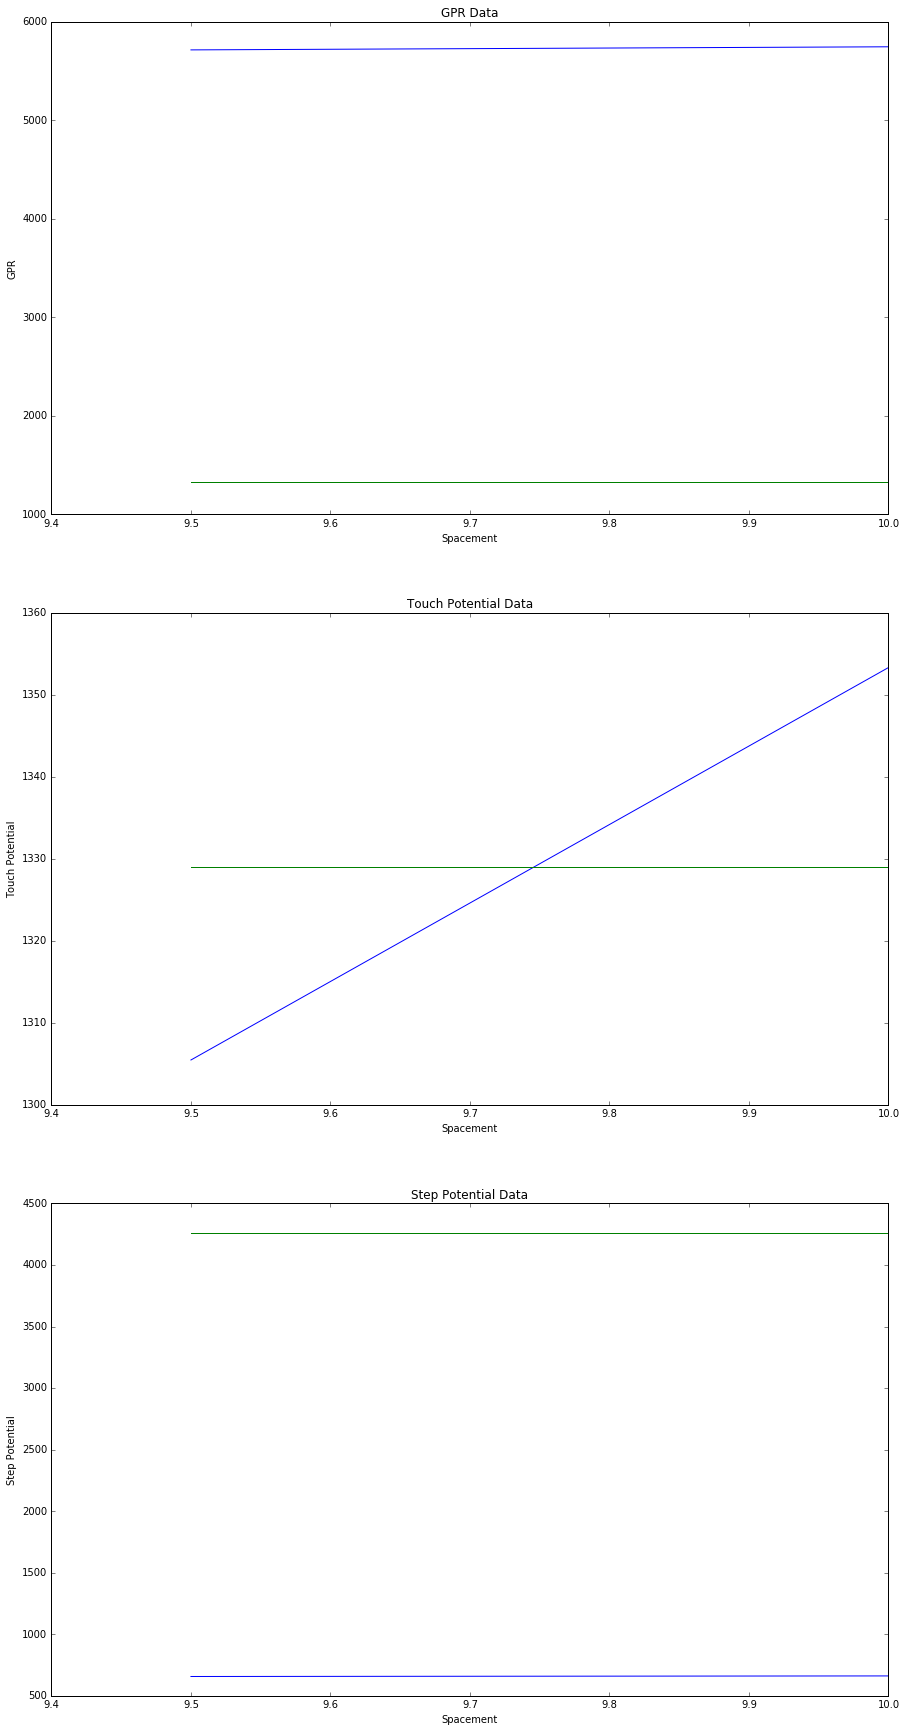

(True,
 0.01,
 1171.578947368421,
 9.5,
 [{'labels': ['GPR', 'Spacement'],
   'lines': [[[10, 9.5], [5746.19252055694, 5714.745979676437], 'b'],
    [[10, 9.5], [1329.022974341125, 1329.022974341125], 'g']],
   'title': 'GPR Data'},
  {'labels': ['Touch Potential', 'Spacement'],
   'lines': [[[10, 9.5], [1353.305389374128, 1305.4826426797488], 'b'],
    [[10, 9.5], [1329.022974341125, 1329.022974341125], 'g']],
   'title': 'Touch Potential Data'},
  {'labels': ['Step Potential', 'Spacement'],
   'lines': [[[10, 9.5], [661.4900780468466, 656.8571042310664], 'b'],
    [[10, 9.5], [4262.903879962099, 4262.903879962099], 'g']],
   'title': 'Step Potential Data'}])

In [121]:
case_info = {
    'name' : 'ASD',
    'trip_time' : 0.2,
    'ground_ro' : 400,
    'gravel_ro' : 2500,
    'gravel_depth' : 0.102,
    'width' : 70,
    'height' : 70,
    'depth' : 0.5,
    'spacement' : 10,
    'if_ground_rods' : False,
    'rods_length' : 0,
    'rods_number' : 0,
    'max_grid_current' : 2000,
    'fault_current' : 8.814,
    'conductor_kf' : 7.06,
    'increment_step' : 0.5
}


evaluate_case(case_info)

In [105]:
dic = {
    'teste':'macaco',
    'azulao':'azuleta',
    'numero':20,
    'comida':'banana'
}


var_list = ['teste', 'azulao', 'numero', 'comida']


for cat in var_list:
    
foo = dict((cat,dic[cat])for cat in var_list) 
print(foo)

{'azulao': 'azuleta', 'numero': 20, 'teste': 'macaco', 'comida': 'banana'}


doing calc for spacement = 7m
0.889608517824586
doing calc for spacement = 6.5m
0.8680499747589654
doing calc for spacement = 6.0m
0.844967815399228
doing calc for spacement = 5.5m
0.8201404191026942
doing calc for spacement = 5.0m
0.7932980839200245
doing calc for spacement = 4.5m
0.7641105786950384
doing calc for spacement = 4.0m
0.7321728455785488
doing calc for spacement = 3.5m
0.6969924547655152
doing calc for spacement = 3.0m
0.6579923611366824
doing calc for spacement = 2.5m
0.6145759335412208
doing calc for spacement = 2.0m
0.5664203133974388
doing calc for spacement = 1.5m
0.5146277297754377
doing calc for spacement = 1.0m
0.4663741379799984


In [66]:
(kii/kh)*math.log(8/(math.pi*(2*n-1)))

-0.9817078740236755

In [67]:
math.log((math.pow(spacement,2)/(16*depth*diameter))
                             +(math.pow(spacement+2*depth, 2)/(8*spacement*diameter))-(depth/(4*diameter)))

6.571283042360924